In [1]:
from tqdm import tqdm
from itertools import combinations
from pathlib import Path
import sys
import warnings
import logging
from pprint import pformat
import traceback

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.pyplot import MultipleLocator
import seaborn as sns
import statsmodels.api as sm
from scipy.stats import norm
from sklearn.cluster import AgglomerativeClustering
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import silhouette_score, make_scorer
from scipy.stats import uniform
from sklearn.metrics import fbeta_score
import dynamic_yaml
import yaml

sys.path.append("/tf/correlation-coef-predict/ywt_library")
import data_generation
from data_generation import data_gen_cfg
from stl_decompn import stl_decompn
from corr_property import calc_corr_ser_property


with open('../config/data_config.yaml') as f:
    data = dynamic_yaml.load(f)
    data_cfg = yaml.full_load(dynamic_yaml.dump(data))

warnings.simplefilter("ignore")
logging.basicConfig(level=logging.INFO)
matplotlib_logger = logging.getLogger("matplotlib")
matplotlib_logger.setLevel(logging.ERROR)
mpl.rcParams[u'font.sans-serif'] = ['simhei']
mpl.rcParams['axes.unicode_minus'] = False
# logger_list = [logging.getLogger(name) for name in logging.root.manager.loggerDict]
# print(logger_list)

# %load_ext pycodestyle_magic
# %pycodestyle_on --ignore E501
logging.debug(pformat(data_cfg, indent=1, width=100, compact=True))

time: 1.11 s (started: 2022-11-24 09:15:59 +00:00)


# Prepare data

## Data implement & output setting & testset setting

In [2]:
res_dir = Path('./results/')
res_dir.mkdir(parents=True, exist_ok=True)


# setting of output files
save_corr_data = True
save_arima_resid_data = False
# data implement setting
data_implement = "SP500_20082017"  # ['BITCOIN_NVDA', 'PAPER_EVA_1', 'PAPER_EVA_2', 'PAPER_EVA_3',
                                                          # 'PAPER_EVA_4', 'PAPER_EVA_5', 'SP500_19972007', 'SP500_20082017',
                                                          # 'SP500_20082017_CONSUMER_DISCRETIONARY', 'TEST_CASE', TETUAN_POWER', 'TW50_20082018']
# etl set setting
etl_items_setting = "-etl_all"  # -etl_train|-etl_all
# data split period setting, only suit for only settings of Korean paper
data_split_setting = "-data_sp_test2"
# Decide how to calculate corr_ser
corr_ser_clac_method = "corr_ser_calc_abs" # corr_ser_calc_regular|corr_ser_calc_abs

time: 625 µs (started: 2022-11-24 09:16:00 +00:00)


In [3]:
dataset_df = pd.read_csv(data_cfg["DATASETS"][data_implement]['FILE_PATH'])
dataset_df = dataset_df.set_index('Date')
all_set = list(dataset_df.columns)  # all data
train_set = data_cfg["DATASETS"][data_implement]['TRAIN_SET']
test_set = data_cfg['DATASETS'][data_implement]['TEST_SET'] if data_cfg['DATASETS'][data_implement].get('TEST_SET') else [p for p in all_set if p not in train_set]  # all data - train data
logging.info(f"===== len(train_set): {len(train_set)}, len(all_set): {len(all_set)}, len(test_set): {len(test_set)} =====")

# test items implement settings
items_implement = train_set if etl_items_setting == "-etl_train" else all_set
logging.info(f"===== len(etl set): {len(items_implement)} =====")

# setting of name of output files and pictures title
output_file_name = data_cfg["DATASETS"][data_implement]['OUTPUT_FILE_NAME_BASIS'] + etl_items_setting
fig_title = data_implement + etl_items_setting + data_split_setting
logging.info(f"===== file_name basis:{output_file_name}, fig_title basis:{fig_title} =====")
# display(dataset_df)

INFO:root:===== len(train_set): 150, len(all_set): 446, len(test_set): 296 =====
INFO:root:===== len(etl set): 446 =====
INFO:root:===== file_name basis:sp500_20082017-etl_all, fig_title basis:SP500_20082017-etl_all-data_sp_test2 =====


time: 117 ms (started: 2022-11-24 09:16:00 +00:00)


## Load or Create Correlation Data

In [4]:
corr_data_dir = Path(data_cfg["DIRS"]["PIPELINE_DATA_DIR"])/f"{output_file_name}-corr_data"
corr_data_dir.mkdir(parents=True, exist_ok=True)
data_length = int(len(dataset_df)/data_gen_cfg["CORR_WINDOW"])*data_gen_cfg["CORR_WINDOW"]
corr_ser_len_max = int((data_length-data_gen_cfg["CORR_WINDOW"])/data_gen_cfg["CORR_STRIDE"])
max_data_div_start_add = 0  # In the Korea paper, each pair has 5 corr_series(due to diversifing train data).
                            # BUT we only need to take one, so take 0 as arg.
corr_ind = []

# DEFAULT SETTING: data_gen_cfg["DATA_DIV_STRIDE"] == 20, data_gen_cfg["CORR_WINDOW"]==100, data_gen_cfg["CORR_STRIDE"]==100
data_end_init = corr_ser_len_max * data_gen_cfg["CORR_STRIDE"]
for i in range(0, max_data_div_start_add+1, data_gen_cfg["DATA_DIV_STRIDE"]):
    corr_ind.extend(list(range(data_gen_cfg["CORR_WINDOW"]-1+i, data_end_init+bool(i)*data_gen_cfg["CORR_STRIDE"], data_gen_cfg["CORR_STRIDE"])))  # only suit for settings of paper

train_df_path = corr_data_dir/f"{output_file_name}-corr_train.csv"
dev_df_path = corr_data_dir/f"{output_file_name}-corr_dev.csv"
test1_df_path = corr_data_dir/f"{output_file_name}-corr_test1.csv"
test2_df_path = corr_data_dir/f"{output_file_name}-corr_test2.csv"
all_corr_df_paths = dict(zip(["train_df", "dev_df", "test1_df", "test2_df"],
                             [train_df_path, dev_df_path, test1_df_path, test2_df_path]))
if all([df_path.exists() for df_path in all_corr_df_paths.values()]):
    corr_datasets = [pd.read_csv(df_path, index_col=["items"]) for df_path in all_corr_df_paths.values()]
else:
    corr_datasets = data_generation.gen_train_data(items_implement, raw_data_df=dataset_df, corr_ser_len_max=corr_ser_len_max, corr_df_paths=all_corr_df_paths, corr_ind=corr_ind, max_data_div_start_add=max_data_div_start_add, save_file=save_corr_data)

if data_split_setting == "-data_sp_test2":
    corr_dataset = corr_datasets[3]
    display(corr_dataset.head())

,2009-08-03,2009-12-23,2010-05-19,2010-10-11,2011-03-04,2011-07-27,2011-12-16,2012-05-11,2012-10-03,2013-03-01,...,2013-12-13,2014-05-09,2014-10-01,2015-02-25,2015-07-20,2015-12-09,2016-05-04,2016-09-26,2017-02-17,2017-07-12
items,,,,,,,,,,,,,,,,,,,,,
EXR & RCL_0,0.734117,0.905061,0.785018,0.721939,0.671190,-0.351678,0.613028,0.247936,0.728215,0.796137,...,-0.049241,0.817157,0.070484,0.722049,0.211542,0.620790,0.378626,0.467885,-0.063265,-0.147673
EXR & CLX_0,0.773642,0.737735,0.801525,0.884755,0.367367,0.522993,-0.162647,0.725597,0.693520,0.751288,...,-0.243108,-0.253300,0.023788,0.943677,0.293699,0.929081,0.193722,0.560946,0.546624,0.283479
EXR & NSC_0,0.840588,0.722513,0.861761,0.841920,0.660949,0.853405,0.843548,-0.381795,0.592307,0.631024,...,0.108781,0.727363,0.201595,-0.203210,-0.535949,0.599261,0.294131,-0.606118,-0.000291,0.136238
EXR & CXO_0,0.668084,0.829077,0.863273,0.836825,0.874292,-0.304559,0.938664,-0.040469,0.563963,0.332670,...,0.716390,0.897075,0.393437,0.077130,0.002771,0.375815,0.262811,-0.741779,-0.015711,-0.168771
EXR & AKAM_0,0.199625,0.802655,0.972332,0.663723,-0.533803,-0.429652,0.847281,0.399358,0.897392,0.291804,...,0.653256,0.630602,0.498340,0.448854,0.470507,-0.716135,0.186378,0.347881,-0.376157,0.043027


time: 649 ms (started: 2022-11-24 09:16:00 +00:00)


# Calculate properties of Corrlelation series

In [5]:
# stl_decompn(corr_datasets[0].iloc[0,::], overview=True)
if corr_ser_clac_method == "corr_ser_calc_regular":
    corr_property_df_path = res_dir/f"{output_file_name}{data_split_setting}-corr_series_property.csv"
    corr_property_df = calc_corr_ser_property(corr_dataset=corr_dataset, corr_property_df_path=corr_property_df_path)
elif corr_ser_clac_method == "corr_ser_calc_abs":
    # calculate corr_property_df with abs(corr_dataset)
    corr_property_df_path = res_dir/f"{output_file_name}{data_split_setting}-corr_series_abs_property.csv"
    corr_property_df = calc_corr_ser_property(corr_dataset=corr_dataset.abs(), corr_property_df_path=corr_property_df_path)

display(corr_property_df)

,corr_stl_period,corr_stl_resid,corr_stl_trend_std,corr_stl_trend_coef,corr_ser_mean,corr_ser_std
items,,,,,,
EXR & RCL_0,10,0.272146,0.073888,-0.020914,0.515893,0.285543
EXR & CLX_0,10,0.332106,0.061853,-0.013950,0.520040,0.286606
EXR & NSC_0,10,0.305641,0.110666,-0.032858,0.531261,0.276599
EXR & CXO_0,10,0.326568,0.092229,-0.026504,0.504015,0.327457
EXR & AKAM_0,10,0.277975,0.055907,-0.016040,0.535779,0.254628
...,...,...,...,...,...,...
ZION & DIS_0,8,0.383745,0.045888,-0.008111,0.605698,0.238778
ZION & SP500_0,10,0.641042,0.061926,-0.017982,0.591015,0.276741
RSG & DIS_0,10,0.370817,0.044980,0.008043,0.582340,0.334872


time: 8min 22s (started: 2022-11-24 09:16:01 +00:00)


# Clustring

## calculate dissimilarity matrix

In [6]:
def process_index(items):
    item_1 = items[0].strip(" ")
    item_2 = items[1].strip(" ")
    item_2 = item_2[:-2]

    return (item_1, item_2)


def gen_dissimilarity_mat(data_ser: "multi-ind pd.Series", raw_df: "pd.DataFrame", input_similiarity: bool = True):
    data_ser = data_ser.copy()
    tmp_df = data_ser.unstack()
    unstack_missing_items = [item for item in raw_df.columns if item not in tmp_df.columns or item not in tmp_df.index]   # 只靠.unstack()來轉換會漏掉兩組item，.unstack()後的df 不具有這兩組item的自己對自己的row｜col
    for item in unstack_missing_items:
        data_ser.loc[item, item] = 0

    non_symmetry_mat = data_ser.unstack(fill_value=0)
    dissimilarity_mat = non_symmetry_mat.T + non_symmetry_mat
    non_symmetry_mat_sum_double = round(non_symmetry_mat.sum().sum() * 2, 10)
    dissimilarity_mat_sum = round(dissimilarity_mat.sum().sum(), 10)
    assert non_symmetry_mat_sum_double == dissimilarity_mat_sum, "Error happens during the computation of dissimilarity matrix."
    assert not dissimilarity_mat.isnull().any().any(), "Dissimilarity matrix contains missing values."
    np.fill_diagonal(dissimilarity_mat.values, 1)  # check by: tmp_df = gen_data_corr(["A", "A"], dataset_df, corr_ser_len_max=corr_ser_len_max, corr_ind=corr_ind, max_data_div_start_add=max_data_div_start_add); tmp_df.iloc[::, 3:].mean(axis=1)
    if input_similiarity:
        dissimilarity_mat = 1 - dissimilarity_mat.abs()  # This might get wrong by using abs(), because that would mix up corr = -1 & corr = 1

    return dissimilarity_mat


corr_mean = corr_property_df["corr_ser_mean"]
corr_mean.index = corr_dataset.index.str.split('&').map(process_index)
dissimilarity_mat = gen_dissimilarity_mat(corr_mean, dataset_df,  input_similiarity=False)
display(dissimilarity_mat.head())

items,A,AAL,AAP,AAPL,ABC,ABT,ACN,ADBE,ADI,ADM,...,XEC,XEL,XL,XLNX,XOM,XRAY,XRX,YUM,ZBH,ZION
items,,,,,,,,,,,,,,,,,,,,,
A,1.000000,0.417911,0.413044,0.569313,0.606885,0.490913,0.533516,0.594356,0.573232,0.511222,...,0.547782,0.426437,0.551698,0.563115,0.396081,0.586568,0.537093,0.542371,0.580842,0.556948
AAL,0.417911,1.000000,0.440838,0.417642,0.428421,0.400704,0.421516,0.457124,0.512958,0.377979,...,0.419531,0.330255,0.504293,0.523695,0.305808,0.418892,0.403849,0.401264,0.490575,0.388681
AAP,0.413044,0.440838,1.000000,0.449524,0.445642,0.557524,0.455821,0.497260,0.461422,0.540047,...,0.463503,0.459752,0.505721,0.369032,0.354940,0.437465,0.460412,0.512614,0.497631,0.393220
AAPL,0.569313,0.417642,0.449524,1.000000,0.551685,0.542572,0.527239,0.597829,0.558619,0.490320,...,0.459050,0.342227,0.596856,0.511481,0.454034,0.483329,0.523042,0.501512,0.502916,0.445624
ABC,0.606885,0.428421,0.445642,0.551685,1.000000,0.585103,0.458809,0.497896,0.489139,0.530302,...,0.517073,0.498165,0.514886,0.490797,0.321931,0.437764,0.481086,0.493593,0.547703,0.450952


time: 232 ms (started: 2022-11-24 09:24:23 +00:00)


## calculate cluster label for each data

In [11]:
def calc_silhouette_label_freq_std(estimator: "sklearn.cluster.<cluster_model>", X: "pd.DataFrame", silhouette_score_ratio: int = 0.1, silhouette_metric: str = "precomputed") -> float:
    estimator.fit(X)
    cluster_labels = estimator.labels_
    num_labels = len(set(cluster_labels))
    num_samples = len(X.index)
    labels_symbol, label_freq = np.unique(cluster_labels, return_counts=True)
    if num_labels == 1 or num_labels == num_samples:
        return -1
    else:
        return silhouette_score_ratio * silhouette_score(X, cluster_labels, metric=silhouette_metric) + (1 - silhouette_score_ratio) * (1 / np.array(label_freq).std())


def hrchy_clustering_distance_threshold_rs(X: "pd.DataFrame", data_mat_mode: str = "precomputed", verbose: int = 0):

    param_dict = {"n_clusters": [None], "affinity": [data_mat_mode],
                  "linkage": ["single", "complete", "average"],
                  "distance_threshold": uniform(loc=0.55, scale=0.6)}
    cv = [(slice(None), slice(None))]
    hrchy_clustering_rs = RandomizedSearchCV(estimator=AgglomerativeClustering(), param_distributions=param_dict,
                                             n_iter=100000, scoring=calc_silhouette_label_freq_std, cv=cv, n_jobs=-1)
    hrchy_clustering_rs.fit(X)

    if verbose==1:
        print(f"hrchy_clustering_rs.best_estimator_: {hrchy_clustering_rs.best_estimator_}")
        print(f"hrchy_clustering_rs.best_params_: {hrchy_clustering_rs.best_params_}")
        print(f"hrchy_clustering_rs.best_score_: {hrchy_clustering_rs.best_score_}")
        print(f"hrchy_clustering_rs.best_estimator_.n_leaves_: {hrchy_clustering_rs.best_estimator_.n_leaves_}")
        print(f"hrchy_clustering_rs.best_estimator_.n_clusters_: {hrchy_clustering_rs.best_estimator_.n_clusters_}")
        print(f"np.unique(hrchy_clustering_rs.best_estimator_.labels_): {np.unique(hrchy_clustering_rs.best_estimator_.labels_, return_counts=True)}")
        print(f"hrchy_clustering_rs.best_estimator_.labels_: {hrchy_clustering_rs.best_estimator_.labels_}")
        print(f"hrchy_clustering_rs.n_features_in_: {hrchy_clustering_rs.n_features_in_}")
        print(f"hrchy_clustering_rs.feature_names_in_: {hrchy_clustering_rs.feature_names_in_}")
        print("-"*50)

    return hrchy_clustering_rs.best_estimator_


def hrchy_clustering_n_cluster_gs(X: "pd.DataFrame", data_mat_mode: str = "precomputed", verbose: int = 0):

    param_dict = {"n_clusters": range(2, 20), "affinity": [data_mat_mode],
                  "linkage": ["single", "complete", "average"]}
    cv = [(slice(None), slice(None))]
    hrchy_clustering_gs = GridSearchCV(estimator=AgglomerativeClustering(), param_grid=param_dict,
                                       scoring=calc_silhouette_label_freq_std, cv=cv, n_jobs=-1)
    hrchy_clustering_gs.fit(X)

    if verbose==1:
        print(f"hrchy_clustering_gs.best_estimator_: {hrchy_clustering_gs.best_estimator_}")
        print(f"hrchy_clustering_gs.best_params_: {hrchy_clustering_gs.best_params_}")
        print(f"hrchy_clustering_gs.best_score_: {hrchy_clustering_gs.best_score_}")
        print(f"hrchy_clustering_gs.best_estimator_.n_leaves_: {hrchy_clustering_gs.best_estimator_.n_leaves_}")
        print(f"hrchy_clustering_gs.best_estimator_.n_clusters_: {hrchy_clustering_gs.best_estimator_.n_clusters_}")
        print(f"np.unique(hrchy_clustering_gs.best_estimator_.labels_): {np.unique(hrchy_clustering_gs.best_estimator_.labels_, return_counts=True)}")
        print(f"hrchy_clustering_gs.best_estimator_.labels_: {hrchy_clustering_gs.best_estimator_.labels_}")
        print(f"hrchy_clustering_gs.n_features_in_: {hrchy_clustering_gs.n_features_in_}")
        print(f"hrchy_clustering_gs.feature_names_in_: {hrchy_clustering_gs.feature_names_in_}")
        print("-"*50)

    return hrchy_clustering_gs.best_estimator_


def obs_hrchy_cluster_instances(X: "pd.DataFrame", data_mat_mode: str = "precomputed", verbose: int = 1):

    for n in range(2, 20):
        hrchy_cluster = AgglomerativeClustering(n_clusters=n, linkage="complete", affinity=data_mat_mode)
        hrchy_cluster.fit(X)

        if verbose==1:
            print(f"hrchy_cluste.n_clusters_: {hrchy_cluster.n_clusters_}")
            print(f"hrchy_cluste.labels and whose instances: {np.unique(hrchy_cluster.labels_, return_counts=True)}")
            # print(f"hrchy_cluster.n_leaves_: {hrchy_cluster.n_leaves_}")
            # print(f"hrchy_cluster.n_features_in_: {hrchy_cluster.n_features_in_}")
            print("-"*50)


def hrchy_cluster_fixed_n_cluster(X: "pd.DataFrame", n: int, data_mat_mode: str = "precomputed", verbose: int = 1):

    hrchy_cluster = AgglomerativeClustering(n_clusters=n, linkage="complete", affinity=data_mat_mode)
    hrchy_cluster.fit(X)

    if verbose==1:
        print(f"hrchy_cluste.n_clusters_: {hrchy_cluster.n_clusters_}")
        print(f"hrchy_cluste.labels and whose instances: {np.unique(hrchy_cluster.labels_, return_counts=True)}")
        print(f"hrchy_cluster.n_leaves_: {hrchy_cluster.n_leaves_}")
        print(f"hrchy_cluster.n_features_in_: {hrchy_cluster.n_features_in_}")
        print("-"*50)

    return hrchy_cluster


obs_hrchy_cluster_instances(dissimilarity_mat)
fixed_n_cluster = 11  # Determin by observe result of obs_hrchy_cluster_instances()
fixed_n_cluster_hrchy_cluster = hrchy_cluster_fixed_n_cluster(dissimilarity_mat, n=fixed_n_cluster)
# distance_threshold_hrchy_cluster = hrchy_clustering_distance_threshold_rs(dissimilarity_mat, verbose=0)
# n_cluster_hrchy_cluster = hrchy_clustering_n_cluster_gs(dissimilarity_mat, verbose=0)

hrchy_cluste.n_clusters_: 2
hrchy_cluste.labels and whose instances: (array([0, 1]), array([142, 304]))
--------------------------------------------------
hrchy_cluste.n_clusters_: 3
hrchy_cluste.labels and whose instances: (array([0, 1, 2]), array([304,  71,  71]))
--------------------------------------------------
hrchy_cluste.n_clusters_: 4
hrchy_cluste.labels and whose instances: (array([0, 1, 2, 3]), array([153, 151,  71,  71]))
--------------------------------------------------
hrchy_cluste.n_clusters_: 5
hrchy_cluste.labels and whose instances: (array([0, 1, 2, 3, 4]), array([151, 103,  71,  71,  50]))
--------------------------------------------------
hrchy_cluste.n_clusters_: 6
hrchy_cluste.labels and whose instances: (array([0, 1, 2, 3, 4, 5]), array([103,  71,  71, 139,  50,  12]))
--------------------------------------------------
hrchy_cluste.n_clusters_: 7
hrchy_cluste.labels and whose instances: (array([0, 1, 2, 3, 4, 5, 6]), array([ 71, 139,  71,  54,  50,  12,  49]))
-

## plot cluster label distribution

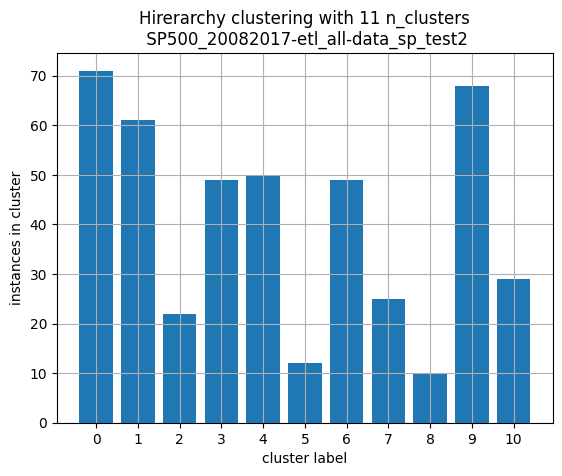

INFO:root:cluster of each point distribution: (array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]), array([71, 61, 22, 49, 50, 12, 49, 25, 10, 68, 29]))


time: 103 ms (started: 2022-11-24 09:24:23 +00:00)


In [8]:
def plot_cluster_labels_distribution(trained_cluster: "sklearn.cluster.<cluster_model>", cluster_name: str):
    x_major_locator = MultipleLocator(1)
    ax = plt.gca()
    ax.xaxis.set_major_locator(x_major_locator)
    plt.bar(np.unique(trained_cluster.labels_, return_counts=True)[0], np.unique(trained_cluster.labels_, return_counts=True)[1])
    plt.grid()
    plt.ylabel("instances in cluster")
    plt.xlabel("cluster label")
    plt.title(f"{cluster_name}\n {fig_title}")
    plt.show()  # findout elbow point
    plt.close()
    logging.info(f"cluster of each point distribution: {np.unique(trained_cluster.labels_, return_counts=True)}")

plot_cluster_labels_distribution(fixed_n_cluster_hrchy_cluster, f"Hirerarchy clustering with {fixed_n_cluster} n_clusters")
# plot_cluster_labels_distribution(n_cluster_hrchy_cluster, "Hirerarchy clustering with n_clusters")
# plot_cluster_labels_distribution(distance_threshold_hrchy_cluster, "Hirerarchy clustering with distance threshold")
# print(hrchy_cluster_labels_df.loc[hrchy_cluster_labels_df["hrchy_cluster_label"]==4, "items"].values)

## output cluster results

In [13]:
cluster_items_dir = Path(data_cfg["DIRS"]["PIPELINE_DATA_DIR"])/f"{output_file_name}-cluster"
cluster_items_dir.mkdir(parents=True, exist_ok=True)

if fixed_n_cluster:
    output_cluster = fixed_n_cluster_hrchy_cluster  # the value of output_cluster depend on performance which shows in plot cluster label distribution
    output_cluster_name = f"corr_mat_hrchy_{fixed_n_cluster}_cluster"

hrchy_cluster_labels_df = pd.DataFrame(output_cluster.labels_, index=dissimilarity_mat.index, columns=[f"{output_cluster_name}_label"]).reset_index()
hrchy_cluster_labels_df.to_csv(cluster_items_dir/f"{output_file_name}-{corr_ser_clac_method}-{output_cluster_name}.csv")
logging.info(f"{output_file_name}-{corr_ser_clac_method}-{output_cluster_name}.csv has been save to {cluster_items_dir}")

INFO:root:sp500_20082017-etl_all-corr_ser_calc_abs-corr_mat_hrchy_11_cluster.csv has been save to /tf/correlation-coef-predict/pipeline_dataset/sp500_20082017-etl_all-cluster


time: 2.57 ms (started: 2022-11-24 09:49:21 +00:00)


# plot correlation coffecient distribution of data

In [10]:
datasets = {'train_data--comb(150,2)': train_corr_series_concat, 'all_data--comb(445,2)': all_corr_series_concat, 'other_data--comb(295,2)': other_corr_series_concat}
etl_types = ["boxplot", "histogram", "qqplot", "Emprical Cumulative Density"]
fig, axes = plt.subplots(figsize=(20, 20),nrows=len(etl_types), ncols=len(datasets), sharex=False, sharey=False, dpi=100)

for row, etl_type in enumerate(etl_types):
    for col,dataset_key in enumerate(datasets):
        # print(row, etl_type, col, dataset_key, datasets[dataset_key])
        s = axes[row, col]
        s.set_title(f"{dataset_key}: \n{etl_type}", fontsize=24)
        if etl_type=="boxplot":
            s.boxplot(datasets[dataset_key], showmeans=True)
        elif etl_type=="histogram":
            s.hist(datasets[dataset_key], bins=[b/10 for b in range(-13,14)])
        elif etl_type=="qqplot":
            percents = [0.001, 0.2, 0.5, 0.8, 0.999]
            #x,y = [norm.ppf(p) for p in percents], [np.quantile(train_corr_series_concat, p) for p in percents]
            x,y = [norm.ppf(p) for p in percents], [np.quantile(datasets[dataset_key], p) for p in percents]
            sm.qqplot(datasets[dataset_key], line='q', ax=s)
            s.scatter(x,y, c='m', marker='x', s=300)
        elif etl_type=="Emprical Cumulative Density":
            pd.Series(datasets[dataset_key]).value_counts().sort_index().cumsum().plot(ax=s)

# 分開, 避免子圖標籤互相重疊
plt.tight_layout()
plt.savefig("./results/dataset_exploration.png")
plt.show()
plt.close()

NameError: name 'train_corr_series_concat' is not defined

time: 359 ms (started: 2022-11-24 09:24:24 +00:00)


In [ ]:
df = pd.DataFrame([[dataset_key, datasets[dataset_key].std()] for dataset_key in datasets], 
                  columns=['Dataset', 'Standard deviation'])
ax = sns.barplot(x='Dataset', y='Standard deviation', data=df)
ax.set_title('std of correlation')
ax.set(ylim=[0.47, 0.475])
ax.bar_label(ax.containers[0])
plt.xticks(rotation=60)
plt.savefig("./results/dataset_exploration_2.png")
plt.show()
plt.close()

In [ ]:
sns.distplot(train_corr_series_concat)
# plt.hist(train_corr_series, bins=[b/10 for b in range(-13,14)])

In [ ]:
train_corr_series_df = gen_corr_series(None, "train_dataset.csv", from_file=True, concat_all=False)
all_corr_series_df = gen_corr_series(None, "445_dataset.csv", from_file=True, concat_all=False)
other_corr_series_df = gen_corr_series(None, "295_dataset.csv", from_file=True, concat_all=False)

In [ ]:
datasets = {'train_data--comb(150,2)': train_corr_series_df, 'all_data--comb(445,2)': all_corr_series_df, 'other_data--comb(295,2)': other_corr_series_df}
etl_types = ["boxplot", "histogram"]
static_types = ["mean", "std"]
fig, axes = plt.subplots(figsize=(30, 30),nrows=len(list(product(etl_types, static_types))), ncols=len(datasets), sharex=False, sharey=False, dpi=100)

for row, (etl_type, static_type) in enumerate(product(etl_types, static_types)):
    for col,dataset_key in enumerate(datasets):
        s = axes[row, col]
        s.set_title(f"{dataset_key}: \n{etl_type}_{static_type}", fontsize=24)
        if etl_type=="boxplot":
            s.boxplot(datasets[dataset_key].iloc[:, ::5].describe().loc[static_type,:], showmeans=True)
        elif etl_type=="histogram":
            s.hist(datasets[dataset_key].iloc[:, ::5].describe().loc[static_type,:], bins=[b/10 for b in range(-13,14)])

fig.suptitle(f"Each correlation_series static property _20220718", fontsize=24)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
# 分開, 避免子圖標籤互相重疊
# plt.tight_layout()
plt.savefig("./results/dataset_exploration_3.png")
plt.show()
plt.close()

In [ ]:
display(train_corr_series_df)
display(train_corr_series_df.iloc[:,::5])
display(train_corr_series_df.iloc[:,::5].describe())
display(train_corr_series_df.iloc[:,::5].describe().loc['std',:])